In [3]:
import pandas as pd
import matplotlib.pyplot as pt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
# from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.layers import InputSpec,Layer
import keras
# from keras.engine import InputSpec, Layer
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
import os
import pandas as pd
import urduhack
urduhack.download()
from urduhack.models.lemmatizer import lemmatizer
from urduhack.normalization import normalize
from urduhack.preprocessing import normalize_whitespace, remove_punctuation,remove_accents,replace_numbers
from urduhack.stop_words import STOP_WORDS
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer


c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train = pd.read_csv('Train_data.csv')
test = pd.read_csv('Test_data.csv')


In [5]:
train

,Sentence,Sentiment
0,['چودھری رحمت علی 16 نومبر1897 کو مشرقی پنجا...,['O']
1,['تقریباً 25 سال کی عمر میں آپ صلی اللہ علیہ و...,['O']
2,['لیاقت علی خان پاکستان کے پہلے وزیراعظم تھے۔ ...,['O']
3,['مرزا غالب 1797- 1869 اردو زبان کے سب سے بڑے ...,['O']
4,['ٹیپو سلطان 10 نومبر1750~ 4 مئی 1799 ہندوستان...,['O']
...,...,...
123,['برطانوی ہندوستان میں رہنے والے شیخ محمد نور ...,['P']
124,['قاروق کا لقب پانے والے حضرت عمر رضی اللہ تعا...,['P']
125,"[""زمیندار جناب حاجی شاہ مشرقی پنجاب کے ضلع ہوش...",['P']
126,['نبی محترمؐ نے حضرت خدیجہؓ کے تجارتی قافلے کے...,['P']


In [6]:
train['Sentiment'] =train['Sentiment'].replace({"['O']": 1, "['P']" :2 , "['NP']":3 })

In [7]:
test['Sentiment'] =test['Sentiment'].replace({"['O']": 1, "['P']" :2 , "['NP']":3 })

In [8]:
train

,Sentence,Sentiment
0,['چودھری رحمت علی 16 نومبر1897 کو مشرقی پنجا...,1
1,['تقریباً 25 سال کی عمر میں آپ صلی اللہ علیہ و...,1
2,['لیاقت علی خان پاکستان کے پہلے وزیراعظم تھے۔ ...,1
3,['مرزا غالب 1797- 1869 اردو زبان کے سب سے بڑے ...,1
4,['ٹیپو سلطان 10 نومبر1750~ 4 مئی 1799 ہندوستان...,1
...,...,...
123,['برطانوی ہندوستان میں رہنے والے شیخ محمد نور ...,2
124,['قاروق کا لقب پانے والے حضرت عمر رضی اللہ تعا...,2
125,"[""زمیندار جناب حاجی شاہ مشرقی پنجاب کے ضلع ہوش...",2
126,['نبی محترمؐ نے حضرت خدیجہؓ کے تجارتی قافلے کے...,2


In [42]:
from collections import Counter
def create_vocab(df):
    vocab = Counter()
    for i in range(df.shape[0]):
        vocab.update(df.Sentence[i].split())
    return(vocab)

In [43]:
# concatenate training and testing datasets
master=pd.concat((train,test)).reset_index(drop=True)

# call vocabulary creation function on master dataset
vocab = create_vocab(master)

# lets check the no. of words in the vocabulary
len(vocab)

3054

In [11]:
vocab.most_common(50)

[('کے', 2034),
 ('میں', 1821),
 ('کی', 1721),
 ('سے', 1113),
 ('کو', 1057),
 ('نے', 1037),
 ('اور', 1020),
 ('آپ', 872),
 ('کا', 757),
 ('کر', 438),
 ('پر', 385),
 ('ایک', 295),
 ('بعد', 281),
 ('بھی', 270),
 ('پاکستان', 254),
 ('کہ', 246),
 ('اس', 241),
 ('حضرت', 224),
 ('اپنے', 219),
 ('ہو', 211),
 ('علی', 200),
 ('ہی', 190),
 ('وہ', 188),
 ('کیا', 186),
 ('حاصل', 180),
 ('ان', 179),
 ('ہے۔', 175),
 ('خان', 172),
 ('تعلیم', 165),
 ('جو', 164),
 ('اپنی', 157),
 ('کرنے', 154),
 ('لئے', 153),
 ('نام', 152),
 ('سال', 151),
 ('بہت', 147),
 ('تھا۔', 147),
 ('انہوں', 142),
 ('کی۔', 140),
 ('تھے۔', 139),
 ('کیا۔', 139),
 ('جس', 130),
 ('و', 128),
 ('ہے', 127),
 ('پیدا', 126),
 ('تو', 123),
 ('عمر', 121),
 ('شاہ', 120),
 ('محمد', 118),
 ('تھے', 116)]

In [44]:
# create the final vocab by considering words with more than one occurence
# create the final vocab by considering words with more than one occurence
final_vocab = []
min_occur = 2
for k,v in vocab.items():
    if v >= min_occur:
        final_vocab.append(k)

In [45]:
# lets check the no. of the words in the final vocabulary
vocab_size = len(final_vocab)
vocab_size

3054

In [46]:
def filter(tweet):
    sentence = ""
    for word in tweet.split():  
        if word in final_vocab:
            sentence = sentence + word + ' '
    return(sentence)

In [47]:
train['Sentence'] = train['Sentence'].apply(lambda s : filter(s))
test ['Sentence'] = test ['Sentence'].apply(lambda s : filter(s))

In [16]:
train.Sentence.head()


0    ['چودھری رحمت علی 16 کو مشرقی پنجاب کے ضلع ہوش...
1    25 سال کی عمر میں آپ صلی اللہ علیہ و آلہ وسلم ...
2    علی خان پاکستان کے پہلے وزیراعظم تھے۔ آپ ہندوس...
3    ['مرزا غالب اردو زبان کے سب سے بڑے شاعر سمجھے ...
4    سلطان 10 4 مئی ہندوستان میں انگریزوں کے خلاف ج...
Name: Sentence, dtype: object

In [48]:
# the different units into which you can break down text (words, characters, or n-grams) are called tokens, 
# and breaking text into such tokens is called tokenization, this can be achieved using Tokenizer in Keras

from keras.preprocessing.text import Tokenizer
# fit a tokenizer
def create_tokenizer(lines):
    # num_words = vocab_size will create a tokenizer,configured to only take into account the vocab_size(6025)
    tokenizer = Tokenizer(num_words=vocab_size)
    # Build th word index, Turns strings into lists of integer indices
    tokenizer.fit_on_texts(lines) 
    return tokenizer

In [49]:
# create and apply tokenizer on the training dataset
tokenizer = create_tokenizer(train.Sentence)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3016 unique tokens.


In [50]:
train_text = tokenizer.texts_to_matrix(train.Sentence, mode = 'freq')

In [20]:

from keras import preprocessing
# conver text to sequences
sequences = tokenizer.texts_to_sequences(train.Sentence)
#print(sequences)

In [23]:
maxlen =100

In [24]:
from keras_preprocessing.sequence import pad_sequences
train_text = pad_sequences(sequences, maxlen=maxlen)


In [71]:
tokenizer = create_tokenizer(train.Sentence)

In [72]:
from keras import preprocessing
# conver text to sequences
sequences = tokenizer.texts_to_sequences(train.Sentence)
#print(sequences)

In [73]:
from keras_preprocessing.sequence import pad_sequences
train_text = pad_sequences(sequences, maxlen=maxlen)


In [74]:
X_train, X_test, y_train, y_test = train_test_split(train_text, train.Sentiment, test_size = 0.2, random_state = 42)

In [75]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [53]:
X_train.shape

(102, 3054)

In [64]:
max_words = 3054

In [55]:
import os
# glove_dir = "../input/glove6b100dtxt/"
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [65]:

embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # Words not found in the embedding index will be all zeros.

In [76]:
from keras.layers import Embedding, SimpleRNN
model = Sequential()
model.add(Embedding(max_words, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          97728     
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 99,841
Trainable params: 99,841
Non-trainable params: 0
_________________________________________________________________


In [67]:
callbacks_list = [
EarlyStopping(
monitor='get_f1',
patience=1,
),
ModelCheckpoint(filepath='./SRNN.h5',monitor='val_loss',save_best_only=True)
]

In [77]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[get_f1])

history = model.fit(X_train, y_train,
epochs=100,
batch_size=128,
callbacks=callbacks_list,
validation_split=0.2)

Epoch 1/100


c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1/1 [==============================] - 5s 5s/step - loss: 0.8198 - get_f1: 1.3455 - val_loss: 0.4945 - val_get_f1: 1.1111
Epoch 2/100
1/1 [==============================] - 0s 160ms/step - loss: -0.1015 - get_f1: 1.0064 - val_loss: 0.0502 - val_get_f1: 1.0526
Epoch 3/100
1/1 [==============================] - 0s 146ms/step - loss: -0.8069 - get_f1: 1.0000 - val_loss: -0.3737 - val_get_f1: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 147ms/step - loss: -1.0684 - get_f1: 1.0000 - val_loss: -0.9708 - val_get_f1: 1.0000


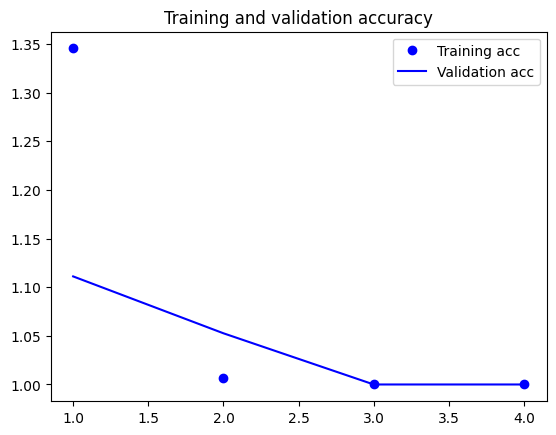

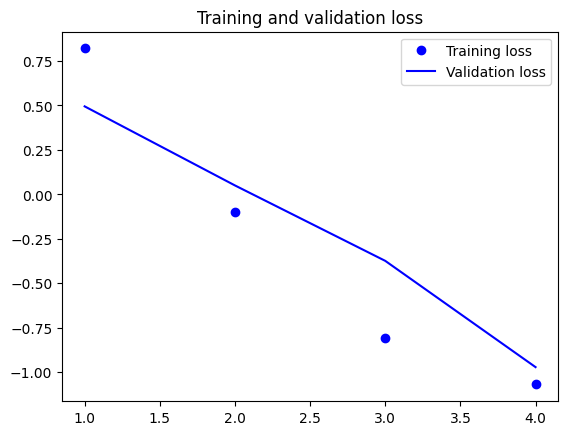

In [80]:
import matplotlib.pyplot as plt
acc = history.history['get_f1']
val_acc = history.history['val_get_f1']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [81]:
# dependencies = {
#     'get_f1': get_f1
# }


# # load the model from disk
# loaded_model_SRNN = keras.models.load_model('./SRNN.h5',custom_objects=dependencies)

In [88]:
# prediction on the test dataset
#X_test_Set = tokenizer.texts_to_matrix(X_test, mode = 'freq')
from sklearn.metrics import accuracy_score, classification_report
# y_pred = loaded_model_SRNN.predict(X_test)
y_pred = np.argmax(model.predict(X_test),axis=1)
print(classification_report(y_test, y_pred))

1/1 [==============================] - 0s 77ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       5.0
           2       0.00      0.00      0.00       8.0
           3       0.00      0.00      0.00      13.0

    accuracy                           0.00      26.0
   macro avg       0.00      0.00      0.00      26.0
weighted avg       0.00      0.00      0.00      26.0



c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dell\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 